**NOTE**: for local run only, google cloud is not supported

Run mlflow container with
```shell
make run-mlflow
```

Open http://0.0.0.0:8000


**IMPORTANT**: notebook will be runned as a dependence when you run MLFlow and be available at [127.0.0.1:9999/notebooks/vol_01_ml_products_02_mflow_powered_classifier.ipynb](http://127.0.0.1:9999/notebooks/vol_01_ml_products_02_mflow_powered_classifier.ipynb)

Note: MLFlow bucket will be created at `docker-entrypoint.sh`

In [60]:
import os
import sys

import pandas as pd
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from dotenv import load_dotenv
import numpy as np

# WARNING: working only at container
root_data_dir = '/opt/ml/data'
if not os.path.exists(root_data_dir):
    raise RuntimeError('Отсутствует директория с данными')
else:
    print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)[:5]))

Содержимое директории /opt/ml/data: ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data']


Загрузим датасет для задачи классификации

In [2]:
import pandas as pd

train_df = pd.read_csv(os.path.join(root_data_dir, 'rtb_classification_data.csv.gz'), compression="gzip")
print(f'Num rows {train_df.shape[0]}, columns {train_df.columns.tolist()}')
train_df.head()

Num rows 1500000, columns ['target', 'sellerClearPrice', 'hour', 'dsp', 'auctionBidFloorSource', 'os', 'lang', 'country', 'region', 'request_context_device_w', 'request_context_device_h', 'adt', 'contype', 'request_context_device_type', 'price']


,target,sellerClearPrice,hour,dsp,auctionBidFloorSource,os,lang,country,region,request_context_device_w,request_context_device_h,adt,contype,request_context_device_type,price
0,0,14.010879,0,76,ml,android,en,US,ct,1200,2000,interstitial,2,5,18.859710
1,0,6.810017,0,80,ml,ios,en,US,mi,393,852,interstitial,2,4,9.166801
2,0,2.499842,8,76,rollouts,android,en,NZ,bop,1080,2400,interstitial,2,4,3.453299
3,0,3.356943,15,80,rollouts,ios,es_US,US,ks,810,1080,interstitial,2,5,4.518700
4,0,1.487904,9,122,ml,android,en,AU,nsw,900,1440,interstitial,2,5,2.055399


In [3]:
train_df['target'].value_counts(normalize=True).

target
0    0.886179
1    0.113821
Name: proportion, dtype: float64

In [4]:
train_df.describe()

,target,sellerClearPrice,hour,dsp,request_context_device_w,request_context_device_h,contype,request_context_device_type,price
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,1.138213e-01,4.066046e+00,1.040133e+01,8.127320e+01,7.185589e+02,1.408871e+03,2.504775e+00,4.228322e+00,5.489304e+00
std,3.175942e-01,5.179376e+00,7.699387e+00,1.789620e+01,2.915723e+02,6.022618e+02,1.219399e+00,4.205130e-01,6.974146e+00
min,0.000000e+00,1.010900e-02,0.000000e+00,2.300000e+01,3.200000e+02,2.000000e+00,0.000000e+00,1.000000e+00,1.064075e-02
25%,0.000000e+00,1.030700e+00,2.000000e+00,7.600000e+01,4.140000e+02,8.960000e+02,2.000000e+00,4.000000e+00,1.415232e+00
50%,0.000000e+00,2.254010e+00,1.100000e+01,8.000000e+01,7.440000e+02,1.180000e+03,2.000000e+00,4.000000e+00,3.069359e+00
75%,0.000000e+00,5.244070e+00,1.700000e+01,8.000000e+01,1.080000e+03,1.920000e+03,2.000000e+00,4.000000e+00,7.087814e+00
max,1.000000e+00,3.714500e+02,2.300000e+01,2.360000e+02,2.960000e+03,3.840000e+03,7.000000e+00,5.000000e+00,5.000000e+02


In [5]:
def get_valuable_columns(input_df):
    col_subset = []
    for col in input_df.columns:
        try:
            most_frequent_value_count = input_df[col].value_counts().iloc[0]
            total_rows = len(input_df)
            if most_frequent_value_count / total_rows <= 0.95:
                col_subset.append(col)
        except (TypeError, IndexError):
            # Ignore columns that can't be analyzed (e.g. mixed data types)
            pass
    return col_subset

columns_subset = get_valuable_columns(train_df)

print(f'Valuable columns subset: {columns_subset}')

Valuable columns subset: ['target', 'sellerClearPrice', 'hour', 'dsp', 'auctionBidFloorSource', 'os', 'lang', 'country', 'region', 'request_context_device_w', 'request_context_device_h', 'contype', 'request_context_device_type', 'price']


In [6]:
cat_candidates = ['request_context_device_type', 'dsp', 'ssp', 'hour']

features = {
    'cat': [col for col in cat_candidates if col in columns_subset],
    'num': ['price', ]
}

features

{'cat': ['request_context_device_type', 'dsp', 'hour'], 'num': ['price']}

In [7]:
# TODO: add train-test split

features_set = features['cat'] + features['num']
X = train_df[features_set]
y = train_df['target']

In [8]:
from catboost import Pool, CatBoostClassifier

from IPython.display import clear_output

model = CatBoostClassifier(**{
    'loss_function': 'CrossEntropy', 'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli', 'n_estimators': 150
})

train_pool = Pool(data=X, label=y, cat_features=features['cat'])
model.fit(train_pool)
clear_output()
print(f'Model trained: {model}')

Model trained: <catboost.core.CatBoostClassifier object at 0xffff413c2cf0>


In [9]:
model_path = os.path.join(root_data_dir, 'model.cb')

model.save_model(model_path)
print(f'model saved to {model_path}')

model saved to /opt/ml/data/model.cb


Home work: review `src/train.py`


In [10]:
f_imp_df = pd.DataFrame({
    'Feature': features_set,
    'Importance': model.get_feature_importance(train_pool)
}).sort_values(by='Importance', ascending=False)

f_imp_df.head()

,Feature,Importance
1,dsp,59.365523
3,price,27.511766
2,hour,7.122617
0,request_context_device_type,6.000094


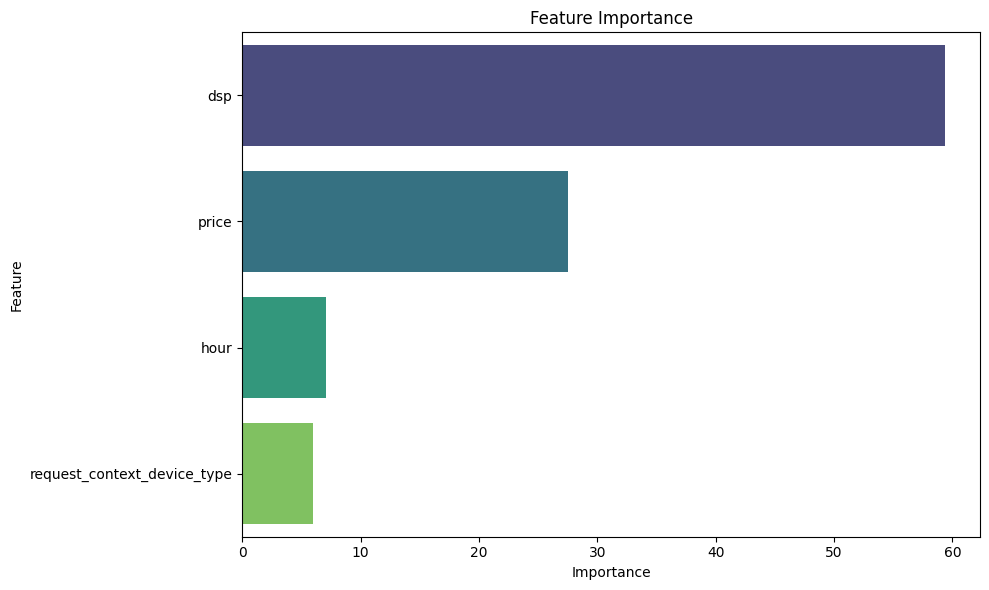

In [11]:
from matplotlib import pyplot as plt

import seaborn as sns

def plot_feature_importances(feature_importances, output_file=None):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances, palette='viridis', dodge=False)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file)
        print(f"Plot saved to {output_file}")
    else:
        plt.show()
plot_feature_importances(f_imp_df)

# Inference

`batch inference` was implemented

In [12]:
X_inference = train_df[features_set]

valid_pool = Pool(data=X_inference, cat_features=features['cat'])
valid_pool
train_df.head(3)

,target,sellerClearPrice,hour,dsp,auctionBidFloorSource,os,lang,country,region,request_context_device_w,request_context_device_h,adt,contype,request_context_device_type,price
0,0,14.010879,0,76,ml,android,en,US,ct,1200,2000,interstitial,2,5,18.859710
1,0,6.810017,0,80,ml,ios,en,US,mi,393,852,interstitial,2,4,9.166801
2,0,2.499842,8,76,rollouts,android,en,NZ,bop,1080,2400,interstitial,2,4,3.453299


In [13]:
predicted_scores = model.predict_proba(valid_pool)
train_df['score'] = predicted_scores[:, 1]

train_df.groupby('auctionBidFloorSource').agg(mean_score = ('score', 'mean')).sort_values(by='mean_score', ascending=False)

,mean_score
auctionBidFloorSource,
user_ml,0.233834
lurl,0.167322
ml,0.136865
rollouts,0.050941
original,0.032186


In [14]:
import plotly.express as px

def plot_hist(filtered_df, metric_name='timedelta_seconds'):
    fig = px.histogram(
        filtered_df, x=metric_name, nbins=10,
        labels={metric_name: f'Title: {metric_name}'},
        title=f'Histogram of {metric_name}'
    )
    fig.show()

# Model registering


Run full pipeline

```shell
make build-sagemaker;
make run-param-tuning;
```

In [42]:
HPO_EXPERIMENT_NAME = "catboost-params"

# mlflow.set_tracking_uri("http://0.0.0.0:8000")
mlflow.set_tracking_uri("http://mlflow_container_ui:8000")
mlflow.set_experiment(HPO_EXPERIMENT_NAME)

client = MlflowClient()
experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)
# choose the best params
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.roc_auc DESC"]
)
print('all complited')

all complited


In [43]:
best_run = runs[0]
best_params = best_run.data.params
best_run_id = best_run.info.run_id
model_params = {i: float(j) for  i,j in best_params.items()}
print(f'{best_run_id}: {model_params}')

a5876329b4814653b48275170731001b: {'depth': 8.0, 'iterations': 350.0, 'l2_leaf_reg': 2.909954052940017, 'learning_rate': 0.12709552437597396}


Saving to S3:

```shell
make run-model-register
```

After model artifact was saved you can observe it at [S3 interface](http://localhost:9001/dashboard)

Validate 1st name - it should matched with the `run name` logged at console

In [46]:
for r in runs:
    print(r.data.tags['mlflow.runName'])

shivering-duck-488
sincere-fowl-563
big-sponge-719
dapper-hound-853
aged-wren-160


In [55]:
with mlflow.start_run(run_id=best_run_id) as active_run:
    artifacts = client.list_artifacts(best_run.info.run_id)
    for artifact in artifacts:
        print(f"Artifact: {artifact.path}, is dir: {artifact.is_dir}")
        artifact_uri = mlflow.get_artifact_uri(artifact.path)
        print(f"Artifact URI: {artifact_uri}")

2025/10/24 10:08:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-duck-488 at: http://mlflow_container_ui:8000/#/experiments/1/runs/a5876329b4814653b48275170731001b.
2025/10/24 10:08:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow_container_ui:8000/#/experiments/1.


Artifact: model, is dir: True
Artifact URI: s3://mlflow/1/a5876329b4814653b48275170731001b/artifacts/model


Check model in interface

In [61]:
from pathlib import Path

def get_file_size(file_path):
    """Get file size in human-readable format"""
    size_bytes = os.path.getsize(file_path)
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024.0:
            return f"{size_bytes:.2f} {unit}"
        size_bytes /= 1024.0
    
    return f"{size_bytes:.2f} PB"

s3_client = boto3.client(
    's3',
    endpoint_url='http://minio:9000',  # Use the alias from docker-compose.yml
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'],
)

response = s3_client.list_buckets()
print("Buckets:")
for bucket in response['Buckets']:
    print(f"  - {bucket['Name']} (Created: {bucket['CreationDate']})")

bucket = os.environ['AWS_BUCKET_NAME']
bucket_names = [bucket['Name'] for bucket in response['Buckets']]
if bucket in bucket_names:
    print(f'Bucket `{bucket}` was found successfully')
    key = artifact_uri.replace(f's3://mlflow/', '')
    local_path = os.path.join(root_data_dir, "downloaded_model.cb")
    s3_client.download_file(bucket, os.path.join(key, 'best_model.cb'), local_path)
    print(f'downloaded to {local_path}, size {get_file_size(local_path)}')

Buckets:
  - mlflow (Created: 2025-10-22 10:19:48.143000+00:00)
Bucket `mlflow` was found successfully
downloaded to /opt/ml/data/downloaded_model.cb, size 1.41 MB
